# Домашнее задание 3
## Сравнение интересов аудитории телеканалов НТВ и Дождь с помощью тематического моделирования LDA

Задача:
Сравнить интересы аудитории телеканолов НТВ и Дождь с помощью методов тематического моделирования
1. Получить данные по аудитории из социальной сети ВК
2. Зарегистрировать приложение, получить app_id, access_token
3. Скачать данные по пользователям в каждой из групп (id групп ВК даны ниже, tvrain_id, ntv_id)
4. Взять небольшую выборку из каждой совокупности телезрителей(около 1000-2000 человек, т.к. 300k-400k слишком много), с которыми работать дальше
5. Обучить LDA модель на их подписках
6. По группам, на которые подписаны эти люди, полуичть ключевые слова групп, на которые они подписаны
7. Получить распределение интересов людей для каждой группы, сравнить на графике

Дополнительно:
- По любой группе пользователей построить матрицу Пользователь-Паблик, где 1 будет означать факт подписки на определенный паблик, 0 - отсутствие подписки (строки - пользователи, столбцы - паблики) и применить PCA - метод главных компонент, посмотреть, что из себя представляют топ-5 компонент и описать, какие интересы пользователей эти компоненты представляют

In [1]:
import seaborn as sb
import sys  
import pandas as pd
import requests
import numpy as np
import datetime
import time
import pickle
import matplotlib.pyplot as plt
import time
%matplotlib inline

from bs4 import BeautifulSoup as bs
import urllib

In [2]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Для использования VK API необходимо создать приложение в VK

1. Создать приложение по адресу https://vk.com/apps?act=manage (кнопка "создать приложение")
2. При создании указать название, описание (можно любые), категория  - прочее. Тип - standalone приложение
3. В настройках получить **app_id**. App_id потребуется для получения access token
4. Авторизовать пользователя (получить access token) можно по адресу: https://vk.com/dev/first_guide, в правилах нас интересует пункт 3 **Авторизация пользователя**
5. После того, как ознакомитесь с авторизацией пользователя, скопируйте в адресную строку такой запрос https://oauth.vk.com/authorize?client_id=5490057&display=page&redirect_uri=https://oauth.vk.com/blank.html&scope=friends&response_type=token&v=5.52, где число **5490057** замените на число, которое получите для вашего **app_id**
6. Нажмите Enter. Откроется окно с запросом прав. В нем отображаются название приложения, иконки прав доступа, и Ваши имя с фамилией. Нажмите «Разрешить». Вы попадете на новую страницу с предупреждением о том, что токен нельзя копировать и передавать третьим лицам. В адресной строке будет URL https://oauth.vk.com/blank.html, а после # Вы увидите дополнительные параметры — access_token, expires_in и user_id. Токен может выглядеть, например, так: 51eff86578a3bbbcb5c7043a122a69fd04dca057ac821dd7afd7c2d8e35b60172d45a26599c08034cc40a
7. Токен — это Ваш ключ доступа. При выполнении определенных условий человек, получивший Ваш токен, может нанести существенный ущерб Вашим данным и данным других людей. Поэтому очень важно не передавать свой токен третьим лицам
8. Поле expires_in содержит время жизни токена в секундах. 86400 секунд — это ровно сутки. Через сутки полученный токен перестанет действовать, для продолжения работы нужно будет получить новый по такому же алгоритму

In [3]:
# use your own app id and respective tokens

# скопируйте сюда ваши app_id и access_token, полученные по методу, описанному выше
app_id = 6876123
access_token = 'cc09e583c52bb492e0c148ff908b99beced48d0ad570e0068add205ab3e33ec6067d14d39b0a90987fb00'

# id групп ВК Дождя и НТВ
tvrain_id = 17568841
ntv_id = 28658784

In [4]:
# проверка работы API и авторизации пользователя. Если возникает ошибка, то, возможно, access token необходимо обновить
check_id = 71553

# api call and test
def vk_get_response(method, parameters, token):
    url = 'https://api.vk.com/method/' + method + '?' + parameters + '&access_token=' + token
#     print url
    return(requests.get(url).json())

answer = vk_get_response(
    'users.get', 'user_ids={0}&v=4.9&lang=ru'.format(check_id), access_token
)['response']
print(answer[0]['first_name'], answer[0]['last_name'])

Павел Асташкин


### Получение подписчиков телеканалов НТВ и Дождь в VK

Получим объекты, которые содержат всю информацию о подпиичиках соответствующих групп (указанных в domains) и сохраним их на диск. Получим в итоге два файла - **ntv_subs** и **tvrain_subs** в формате **.pkl** - питоновский формат хранения данных

In [ ]:
domains = ['ntv', 'tvrain']


for group_domain in domains:
    offset = 0
    group_id = group_domain
    fields = """sex,bdate,city,country,home_town,lists,domain,has_mobile,
    contacts,connections,education,universities,followers_count,occupation,last_seen,relation"""
    first_sample = vk_get_response(
        'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
            group_id, offset, fields
        ), token=access_token
    )
    community_count = first_sample['response']['count']
    community_members = []
    for i in range(community_count // 1000 + 1):
        offset = i * 1000
        try:
            answer = vk_get_response(
                'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
                    group_id, offset, fields), token=access_token
            )
            print("Offset: ", offset)
        except:
            print("Offset: ", offset, " Error")
        community_members += answer['response']['users']
    save_obj(community_members, '{}_subs'.format(group_domain))

Offset:  0
Offset:  1000
Offset:  2000
Offset:  3000
Offset:  4000
Offset:  5000
Offset:  6000
Offset:  7000
Offset:  8000
Offset:  9000
Offset:  10000
Offset:  11000
Offset:  12000
Offset:  13000
Offset:  14000
Offset:  15000
Offset:  16000
Offset:  17000
Offset:  18000
Offset:  19000
Offset:  20000
Offset:  21000
Offset:  22000
Offset:  23000
Offset:  24000
Offset:  25000
Offset:  26000
Offset:  27000
Offset:  28000
Offset:  29000
Offset:  30000
Offset:  31000
Offset:  32000
Offset:  33000
Offset:  34000
Offset:  35000
Offset:  36000
Offset:  37000
Offset:  38000
Offset:  39000
Offset:  40000
Offset:  41000
Offset:  42000
Offset:  43000
Offset:  44000
Offset:  45000
Offset:  46000
Offset:  47000
Offset:  48000
Offset:  49000
Offset:  50000
Offset:  51000
Offset:  52000
Offset:  53000
Offset:  54000
Offset:  55000
Offset:  56000
Offset:  57000
Offset:  58000
Offset:  59000
Offset:  60000
Offset:  61000
Offset:  62000
Offset:  63000
Offset:  64000
Offset:  65000
Offset:  66000
Offset: 

In [5]:
domains = ['tvrain']


for group_domain in domains:
    offset = 0
    group_id = group_domain
    fields = """sex,bdate,city,country,home_town,lists,domain,has_mobile,
    contacts,connections,education,universities,followers_count,occupation,last_seen,relation"""
    first_sample = vk_get_response(
        'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
            group_id, offset, fields
        ), token=access_token
    )
    community_count = first_sample['response']['count']
    community_members = []
    for i in range(community_count // 1000 + 1):
        offset = i * 1000
        try:
            answer = vk_get_response(
                'groups.getMembers', 'group_id={0}&offset={1}&fields={2}&v=4.9&lang=ru'.format(
                    group_id, offset, fields), token=access_token
            )
            print("Offset: ", offset)
        except:
            print("Offset: ", offset, " Error")
        community_members += answer['response']['users']
    save_obj(community_members, '{}_subs'.format(group_domain))

Offset:  0
Offset:  1000
Offset:  2000
Offset:  3000
Offset:  4000
Offset:  5000
Offset:  6000
Offset:  7000
Offset:  8000
Offset:  9000
Offset:  10000
Offset:  11000
Offset:  12000
Offset:  13000
Offset:  14000
Offset:  15000
Offset:  16000
Offset:  17000
Offset:  18000
Offset:  19000
Offset:  20000
Offset:  21000
Offset:  22000
Offset:  23000
Offset:  24000
Offset:  25000
Offset:  26000
Offset:  27000
Offset:  28000
Offset:  29000
Offset:  30000
Offset:  31000
Offset:  32000
Offset:  33000
Offset:  34000
Offset:  35000
Offset:  36000
Offset:  37000
Offset:  38000
Offset:  39000
Offset:  40000
Offset:  41000
Offset:  42000
Offset:  43000
Offset:  44000
Offset:  45000
Offset:  46000
Offset:  47000
Offset:  48000
Offset:  49000
Offset:  50000
Offset:  51000
Offset:  52000
Offset:  53000
Offset:  54000
Offset:  55000
Offset:  56000
Offset:  57000
Offset:  58000
Offset:  59000
Offset:  60000
Offset:  61000
Offset:  62000
Offset:  63000
Offset:  64000
Offset:  65000
Offset:  66000
Offset: 

In [83]:
#community_ntv = load_obj('ntv_subs')
#community_tvrain = load_obj('tvrain_subs')

In [93]:
community_ntv_df = pd.DataFrame(community_ntv)
community_tvrain_df = pd.DataFrame(community_tvrain)

Сначала получим всех уникальных подписчиков НТВ и Дождя с помощью unique. Далее с помощью numpy.random необходимо выбрать небольшой sample (например, по 1000 из каждой группы) таких людей и объединить их вместе

In [94]:
ntv_uids = community_ntv_df.uid.unique().tolist()
tvrain_uids = community_tvrain_df.uid.unique().tolist()

In [10]:
# получить общий список людей из двух выборок НТВ и Дождя, всего должно быть в итоге около 2000 человек
ntv_uids = np.random.choice(ntv_uids, size=1000, replace=False)
tvrain_uids = np.random.choice(tvrain_uids, size=1000, replace=False)
uids = np.append(ntv_uids, tvrain_uids)
uids = list(set(uids))
print(len(uids))
uids[0:5]

2000


[13574147, 13303813, 241033227, 32178216, 253108265]

In [76]:
#save_obj(uids, 'uids')
#uids = load_obj('uids')

In [13]:
# получить подписки этих пользователей
print_counter = 0
final_data = {}

for uid in uids:
    try:
        user_subs = vk_get_response(
            'users.getSubscriptions', 'user_id={0}&v=4.9&lang=ru'.format(int(uid)), access_token
        )
        time.sleep(0.3)
        final_data[uid] = user_subs
    except:
        print("Error")
    if print_counter % 100 == 0:
        print("{0} profiles done".format(print_counter))
    print_counter += 1

0 profiles done
100 profiles done
200 profiles done
300 profiles done
400 profiles done
500 profiles done
600 profiles done
700 profiles done
800 profiles done
900 profiles done
1000 profiles done
1100 profiles done
1200 profiles done
1300 profiles done
1400 profiles done
1500 profiles done
1600 profiles done
1700 profiles done
1800 profiles done
1900 profiles done


In [77]:
#save_obj(final_data, 'final_data')
#final_data = load_obj('final_data')

In [7]:
groups_freq_dict = {}
top_n = 5

for uid in uids:
    try:
        groups = final_data[uid].get('response').get('groups').get('items')[:top_n]
        for group in groups:
            if group not in groups_freq_dict:
                groups_freq_dict[group] = 0
            else:
                groups_freq_dict[group] = groups_freq_dict[group] + 1
    except:
        pass

Загрузка постов со стен групп

In [8]:
group_doc_dict = {}
counter = 0

for group_id, freq in groups_freq_dict.items():
    counter += 1
    try:
        check = vk_get_response(
            'wall.get',
            'owner_id={0}&count=100&fields=post_type,marked_as_ads&&v=4.9&lang=ru'.format(int(group_id)*-1),
            access_token
        )
        check = check['response']
        group_doc = ''
        if check[0] != 0:
            for post in check[1:]:
                if post.get('marked_as_ads') != 1:
                    group_doc += post['text']
        group_doc_dict[group_id] = group_doc
    except:
        print("Response error. Group id {0}".format(group_id))
        print(check)
    if counter % 100 == 0:
        print("{0} groups extracted".format(counter))
    time.sleep(0.4)

100 groups extracted
200 groups extracted
300 groups extracted
Response error. Group id 58616307
{'error': {'error_code': 15, 'error_msg': 'Access denied: this wall available only for community members', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-58616307'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
400 groups extracted
500 groups extracted
600 groups extracted
700 groups extracted
Response error. Group id 35752109
{'error': {'error_code': 15, 'error_msg': 'Access denied: this wall available only for community members', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-35752109'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': '

Response error. Group id 82783290
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-82783290'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 38220604
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-38220604'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 118125923
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {

Response error. Group id 42407470
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-42407470'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 1317768
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-1317768'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 171217676
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'k

Response error. Group id 79936873
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-79936873'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 124437530
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-124437530'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 59135497
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 43882028
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-43882028'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 87153802
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-87153802'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 86973788
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 36510627
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-36510627'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 57409266
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-57409266'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 176119740
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {

Response error. Group id 9084693
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-9084693'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 16775977
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-16775977'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 52046006
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'ke

Response error. Group id 110406504
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-110406504'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 156381671
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-156381671'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 111412177
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'

Response error. Group id 48369111
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-48369111'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 166332815
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-166332815'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 117785855
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'},

Response error. Group id 91487062
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-91487062'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 51512485
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-51512485'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 128900315
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {

Response error. Group id 81853252
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-81853252'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 56595379
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-56595379'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 7265151
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'k

Response error. Group id 42181299
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-42181299'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 166659416
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-166659416'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 178817938
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'},

Response error. Group id 145547032
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-145547032'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 85974477
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-85974477'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 33775112
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 122765959
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-122765959'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 60510194
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-60510194'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 47827817
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 114028847
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-114028847'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 301820
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-301820'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 25671138
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'ke

Response error. Group id 22935147
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-22935147'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 89945018
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-89945018'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 36941068
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 25435258
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-25435258'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 133025135
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-133025135'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 41200854
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 158209155
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-158209155'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 42011632
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-42011632'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 111117910
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'},

Response error. Group id 53956516
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-53956516'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 85387709
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-85387709'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 36788045
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 33191158
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-33191158'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 32231484
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-32231484'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 37119411
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 65
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-65'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 44384363
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-44384363'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 50425283
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'metho

Response error. Group id 11022780
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-11022780'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 90555631
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-90555631'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 74631162
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 50989106
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-50989106'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 29046529
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-29046529'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 65539601
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 64644733
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-64644733'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 133668394
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-133668394'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 433196
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 129752947
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-129752947'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 85396641
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-85396641'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 103065973
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'},

Response error. Group id 12595428
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-12595428'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 52965618
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-52965618'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 75530035
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 101431498
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-101431498'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 74928049
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-74928049'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 42897151
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 174673617
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-174673617'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 152985761
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-152985761'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 162621591
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'

Response error. Group id 134153832
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-134153832'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 211740
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-211740'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 9758
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 

Response error. Group id 178650672
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-178650672'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 61615199
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-61615199'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 35933299
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 20629724
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-20629724'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 25153686
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-25153686'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 30783475
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 32493028
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-32493028'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 65010959
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-65010959'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 80054937
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 149807283
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-149807283'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 172414611
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-172414611'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 96242545
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}

Response error. Group id 96271790
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-96271790'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 31810108
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-31810108'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 67646893
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 3739747
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-3739747'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 9161892
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-9161892'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 90730773
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key'

Response error. Group id 163464542
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-163464542'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 136994127
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-136994127'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 107670957
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'

Response error. Group id 93463463
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-93463463'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 42225457
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-42225457'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 72846817
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 38442606
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-38442606'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 71711391
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-71711391'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 54625306
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 70870022
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-70870022'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 163906453
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-163906453'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 65517328
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 99707783
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-99707783'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 158861435
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-158861435'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 171940088
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'},

Response error. Group id 176610894
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-176610894'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 173520827
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-173520827'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 45386410
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}

Response error. Group id 142845225
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-142845225'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 167785161
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-167785161'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 62608311
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}

Response error. Group id 6418762
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-6418762'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 6836664
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-6836664'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 15211952
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key'

Response error. Group id 171936586
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-171936586'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 154906069
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-154906069'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 98801766
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}

Response error. Group id 31976785
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-31976785'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 46619709
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-46619709'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 91257197
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 9494209
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-9494209'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 19936937
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-19936937'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 22926424
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'ke

Response error. Group id 93962259
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-93962259'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 51559570
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-51559570'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 39080072
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 160192855
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-160192855'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 58990824
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-58990824'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 174574841
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'},

Response error. Group id 55751098
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-55751098'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 100735073
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-100735073'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 7736865
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {

Response error. Group id 134103930
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-134103930'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 49135017
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-49135017'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 72199240
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 145865141
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-145865141'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 37428853
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-37428853'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 32858244
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 118708947
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-118708947'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 177849429
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-177849429'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 115044235
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'

Response error. Group id 117667951
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-117667951'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 163686985
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-163686985'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 162330503
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'

Response error. Group id 68429331
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-68429331'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 158743989
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-158743989'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 73013298
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 25451458
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-25451458'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 11992392
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-11992392'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 34298047
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 23164653
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-23164653'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 23169544
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-23169544'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 34994407
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'

Response error. Group id 163413016
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-163413016'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 92872736
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-92872736'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 46810663
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, 

Response error. Group id 103924276
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-103924276'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}
Response error. Group id 72373074
{'error': {'error_code': 6, 'error_msg': 'Too many requests per second', 'request_params': [{'key': 'oauth', 'value': '1'}, {'key': 'method', 'value': 'wall.get'}, {'key': 'owner_id', 'value': '-72373074'}, {'key': 'count', 'value': '100'}, {'key': 'fields', 'value': 'post_type,marked_as_ads'}, {'key': '', 'value': ''}, {'key': 'v', 'value': '4.9'}, {'key': 'lang', 'value': 'ru'}]}}


KeyboardInterrupt: 

In [9]:
# сохранить сырые данные по постам групп на диск
#save_obj(group_doc_dict, 'group_doc_dict')
#group_doc_dict = load_obj('group_doc_dict')

In [6]:
from bs4 import BeautifulSoup
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from pymorphy2 import MorphAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\astashkin.p.SLV\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\astashkin.p.SLV\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [14]:
chrs_to_delete = string.punctuation + u'»' + u'«' + u'—' + u'“' + u'„' + u'•' + u'#'
translation_table = {ord(c): None for c in chrs_to_delete if c != u'-'}
units = MorphAnalyzer.DEFAULT_UNITS
morph = MorphAnalyzer(result_type=None, units=units)
PortSt = PorterStemmer()
stopw = set(
    [w for w in stopwords.words(['russian', 'english'])]
    + [u'это', u'году', u'года', u'также', u'етот',
       u'которые', u'который', u'которая', u'поэтому',
       u'весь', u'свой', u'мочь', u'eтот', u'например',
       u'какой-то', u'кто-то', u'самый', u'очень', u'несколько',
       u'источник', u'стать', u'время', u'пока', u'однако',
       u'около', u'немного', u'кроме', u'гораздо', u'каждый',
       u'первый', u'вполне', u'из-за', u'из-под',
       u'второй', u'нужно', u'нужный', u'просто', u'большой',
       u'хороший', u'хотеть', u'начать', u'должный', u'новый', u'день',
       u'метр', u'получить', u'далее', u'именно', u'апрель',
       u'сообщать', u'разный', u'говорить', u'делать',
       u'появиться', u'2016',
       u'2015', u'получить', u'иметь', u'составить', u'дать', u'читать',
       u'ничто', u'достаточно', u'использовать',
       u'принять', u'практически',
       u'находиться', u'месяц', u'достаточно', u'что-то', u'часто',
       u'хотеть', u'начаться', u'делать', u'событие', u'составлять',
       u'остаться', u'заявить', u'сделать', u'дело',
       u'примерно', u'попасть', u'хотя', u'лишь', u'первое',
       u'больший', u'решить', u'число', u'идти', u'давать', u'вопрос',
       u'сегодня', u'часть', u'высокий', u'главный', u'случай', u'место',
       u'конец', u'работать', u'работа', u'слово', u'важный', u'сказать']
)

In [15]:
url_start = 'http[s]?://'
url_end = (
    '(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
)
pattern = url_start + url_end

Обработка слов постов групп - трансформация в "хороший" вид. Нормализация и стэмминг, удаление стоп-слов

In [16]:
group_clean_doc_dict = {}
counter = 0

for group_id, doc in group_doc_dict.items():
    soup = BeautifulSoup(doc, 'html.parser')
    body = ' '.join(
        [tag.string.replace('\\n', ' ').replace('\\r', ' ')
         for tag in soup.descendants if tag.string]
    )
    body = re.sub('\[.*?\]','', body)
    body = re.sub(pattern,'', body)
    if body != '':
        body_clean = body.translate(translation_table).lower().strip()
        words = word_tokenize(body_clean)
        tokens = []
        # stemming and text normalization
        for word in words:
            if re.match('^[a-z0-9-]+$', word) is not None:
                tokens.append(PortSt.stem(word))
            elif word.count('-') > 1:
                tokens.append(word)
            else:
                normal_forms = morph.normal_forms(word)
                tokens.append(normal_forms[0] if normal_forms else word)
        # remove stopwords and leave unique words only
        tokens = filter(
            lambda token: token not in stopw, sorted(set(tokens))
        )

        # remove all words with more than 3 chars
        tokens = filter(lambda token: len(token) > 3, tokens)
    else:
        tokens = []
    counter += 1
    if counter % 100 == 0:
        print("{0} docs processed".format(counter))
    group_clean_doc_dict[group_id] = tokens

group_clean_doc_dict = {key: list(val) for key, val in group_clean_doc_dict.items()}

100 docs processed
200 docs processed
300 docs processed
400 docs processed
500 docs processed
600 docs processed
700 docs processed
800 docs processed
900 docs processed
1000 docs processed
1100 docs processed
1200 docs processed
1300 docs processed
1400 docs processed
1500 docs processed
1600 docs processed
1700 docs processed
1800 docs processed
1900 docs processed
2000 docs processed
2100 docs processed
2200 docs processed
2300 docs processed
2400 docs processed


In [9]:
# сохранить обработанные данные на диск
#save_obj(group_clean_doc_dict, 'group_doc_dict_clean')
#group_clean_doc_dict = load_obj('group_doc_dict_clean')
#final_data = load_obj('final_data')

### Обучение LDA модели

In [10]:
from gensim.corpora import TextCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

class ListTextCorpus(TextCorpus):

    def get_texts(self):
        for doc in self.input:
            yield doc
                
mycorp = ListTextCorpus(input=group_clean_doc_dict.values())
justlda = LdaModel(
    corpus=mycorp, num_topics=20, passes=12
)

In [11]:
print('LdaModel performance')
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))

LdaModel performance
0 девушка жизнь фото телефон семья улица состояние интернет жить никто
1 айта біль мена баста ислам человек адам течь жәннатта жүріп
2 телефон фара задний ручка норма писать стекло порядок активный цена
3 друг 1990 увидеть сотка взять душить вceть жизнь blue 1984
4 мороженое лефс хоткейка оладья-карри гороховый новопесчаный бургера-блин палачинк припёк пфанкухен
5 человек рука размер готовый друг найти знать вместе группа чёрный
6 жизнь твой ждать смотреть маленький человек жить написать видео 2019
7 знать пожалуйста блюдo пpямo бyдь пoдapoк кopoлeв yмeть yxoдить жaлкo
8 ждать россия купить видеть фото смотреть думать друг играть комментарий
9 утро 2019 ассистый окупаемость version любить левый фото ждать лига
10 смотреть чувство текила дымный нержавейка грандиозный комедия отличный кальян умеренный
11 человек друг жизнь знать ждать вместе писать пройти найти любить
12 глава район администрация житель сотрудник ребёнок область гражданин организация территория
13 mu

In [72]:
dummy_dict = {key: 0 for key in range(20)}

group_topics_dict_20 = {
    group_id: dict(list(dummy_dict.items()) + justlda.get_document_topics(mycorp.dictionary.doc2bow(text)))
    for group_id, text in group_clean_doc_dict.items()
}
check_pd_20 = pd.DataFrame.from_dict(group_topics_dict_20, orient='index')
print("Group distribution by the most relevant topic")
pd.Series.round(check_pd_20.idxmax(axis=1).value_counts() * 1. / len(check_pd_20), 2)

Group distribution by the most relevant topic


11    0.56
12    0.15
5     0.06
0     0.04
13    0.02
8     0.02
19    0.02
15    0.02
16    0.02
6     0.01
9     0.01
14    0.01
17    0.01
1     0.01
10    0.01
7     0.01
3     0.01
2     0.01
18    0.01
4     0.00
dtype: float64

In [14]:
print("The most typical groups for every topic")
for i in range(20):
    terms = justlda.get_topic_terms(i)
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))
    typical_groups = check_pd_20[i].sort_values(ascending=False).index[:10]
    for g in typical_groups:
        group_info = vk_get_response(
            'groups.getById', 'group_ids={0}&v=4.9&lang=ru'.format(g), access_token
        )
        print(group_info['response'][0]['name'] + ' ' + 'http://vk.com/club' + str(g))
        time.sleep(0.3)
    print()

The most typical groups for every topic
0 девушка жизнь фото телефон семья улица состояние интернет жить никто
Аренда Красноярск http://vk.com/club76347737
АРЕНДА Красноярск http://vk.com/club76867861
Аренда в Красноярске http://vk.com/club58288854
Лекториум http://vk.com/club134121211
Про Авто http://vk.com/club31128331
Мужской рай http://vk.com/club38290762
Чёрно-белая фотография http://vk.com/club29937606
Подслушано ℬ Староюрьево http://vk.com/club111802007
Убойные приколы http://vk.com/club133344151
Полезно знать http://vk.com/club148569250

1 айта біль мена баста ислам человек адам течь жәннатта жүріп
ҚҰРДАСТАР http://vk.com/club99980617
УНИАН | УНІАН http://vk.com/club24187484
Мысли вслух ♔ http://vk.com/club75051476
◆ҚАЗАҚША ХАДИСТЕР◆ http://vk.com/club88219133
Ислам арулары🌷 http://vk.com/club75417123
ММА | Хабиб Нурмагомедов http://vk.com/club87203018
Вікіпедія http://vk.com/club37038684
Спокойной ночи голыши [DFM] http://vk.com/club26342040
Галоча в Vk http://vk.com/club66692

Интернет-магазин ДНР-Маркет #DNR_MARKET http://vk.com/club120860079
Объявления|Продаю 03|Барахолка| Бурятия Улан-Удэ http://vk.com/club61910697
Любимый Мой ∞ http://vk.com/club43498930
Рецепты http://vk.com/club34451036
анекдотов.net http://vk.com/club22222333

15 ждать жизнь дoлжный выйти чeлoвeкa хoтить мoжнo человек cвязь paньшe
Panda Art Café http://vk.com/club38691559
Оптимист http://vk.com/club39410028
ЕБ*НУТЬСЯ http://vk.com/club49297041
"Другое место" http://vk.com/club179134050
Virtual Playing - V-PLAY.RU http://vk.com/club53468361
ЭТУ СТРАНУ НЕ ПОБЕДИТЬ!!! http://vk.com/club36200261
Brighton Beach http://vk.com/club46521427
Armin van Buuren http://vk.com/club42743690
Мир Футбола http://vk.com/club31687
I'm a Footballer | ФУТБОЛ http://vk.com/club26544717

16 бавария наполоть силва челси ювентус ливерпуль реал роналда мане лион
Лига чемпионов УЕФА http://vk.com/club88165975
Реальный Футбол http://vk.com/club71474813
ФУТБОЛ: Лига Чемпионов http://vk.com/club25450736
Тру Художни

In [73]:
check_pd_20.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
755,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.997339,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
1980,0.0,0.0,0.0,0.0,0.0,0.041150,0.0,0.0,0.0,0.0,0.0,0.812031,0.000000,0.096153,0.0,0.049851,0.000000,0.0,0.0,0.0
3168,0.0,0.0,0.0,0.0,0.0,0.039827,0.0,0.0,0.0,0.0,0.0,0.742336,0.138474,0.000000,0.0,0.000000,0.078725,0.0,0.0,0.0
4059,0.0,0.0,0.0,0.0,0.0,0.027405,0.0,0.0,0.0,0.0,0.0,0.595004,0.377153,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
31687,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.293262,0.000000,0.000000,0.0,0.704167,0.000000,0.0,0.0,0.0
36039,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.560591,0.438740,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
48864,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.998205,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
53474,0.0,0.0,0.0,0.0,0.0,0.016598,0.0,0.0,0.0,0.0,0.0,0.605775,0.370527,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
73476,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.999647,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
89493,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.897452,0.000000,0.101838,0.0,0.000000,0.000000,0.0,0.0,0.0


In [74]:
groups_by_topic = check_pd_20.reset_index()

In [99]:
def affiliation(target_id, list_to_compare):
    if target_id in list_to_compare:
        return 1
    else:
        return 0 

In [96]:
subs_by_groups_ntv = set()
subs_by_groups_tvrain = set()

counter = 0
for uid in uids:
    try:
        usr_subs = final_data[uid].get('response').get('groups').get('items')[:5]
    except:
        continue
    if uid in ntv_uids:
        for group_id in usr_subs:
            subs_by_groups_ntv.add(group_id)
    elif uid in tvrain_uids:
        for group_id in usr_subs:
            subs_by_groups_tvrain.add(group_id)
    else:
        print('unknown')
    counter += 1
    if counter % 100 == 0:
        print("{0} uids processed".format(counter))

100 uids processed
200 uids processed
300 uids processed
400 uids processed
500 uids processed
600 uids processed
700 uids processed
800 uids processed
900 uids processed
1000 uids processed
1100 uids processed
1200 uids processed
1300 uids processed
1400 uids processed
1500 uids processed


In [101]:
groups_by_topic['ntv'] = groups_by_topic.apply(lambda x: affiliation(x['index'], subs_by_groups_ntv), axis=1)
groups_by_topic['tvrain'] = groups_by_topic.apply(lambda x: affiliation(x['index'], subs_by_groups_tvrain), axis=1)

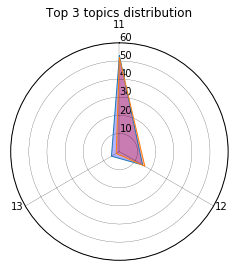

red - ntv
blue - tvrain


In [232]:
# Plots a radar chart.
from math import pi
import matplotlib.pyplot as plt

ntv_distr = groups_by_topic.groupby(by='ntv').aggregate('mean')*100
ntv_distr = ntv_distr.drop(columns=['index', 'tvrain']).iloc[1].tolist()
tvrain_distr = groups_by_topic.groupby(by='tvrain').aggregate('mean')*100
tvrain_distr = tvrain_distr.drop(columns=['index', 'ntv']).iloc[1].tolist()

# Set data
cat = [11, 12, 13]
values1 = ntv_distr[11:14]
values2 = tvrain_distr[11:14]
N = len(cat)
x_as = [n / float(N) * 2 * pi for n in range(N)]

values1 += values1[:1]
values2 += values2[:1]
x_as += x_as[:1]

# Set color of axes
plt.rc('axes', linewidth=1, edgecolor='#000000')
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)

# Set color and linestyle of grid
ax.xaxis.grid(True, color='#000000', linestyle='solid', linewidth=0.2)
ax.yaxis.grid(True, color='#000000', linestyle='solid', linewidth=0.2)

# Set number of radial axes and remove labels
plt.xticks(x_as[:-1], [])

# Plot data
ax.plot(x_as, values1, linewidth=1, linestyle='solid', zorder=3)
ax.fill(x_as, values1, 'blue', alpha=0.3)
ax.plot(x_as, values2, linewidth=1, linestyle='solid', zorder=3)
ax.fill(x_as, values2, 'red', alpha=0.3)

# Set axes limits
plt.ylim(0, 60)

# Draw ytick labels to make sure they fit properly
for i in range(N):
    angle_rad = i / float(N) * 2 * pi
    if angle_rad == 0:
        ha, distance_ax = "center", 10
    elif 0 < angle_rad < pi:
        ha, distance_ax = "left", 1
    elif angle_rad == pi:
        ha, distance_ax = "center", 1
    else:
        ha, distance_ax = "right", 1
    ax.text(angle_rad, 60 + distance_ax, cat[i], size=10, horizontalalignment=ha, verticalalignment="center")
ax.set_title('Top 3 topics distribution', pad=15)
plt.show()
print('red - ntv\nblue - tvrain')

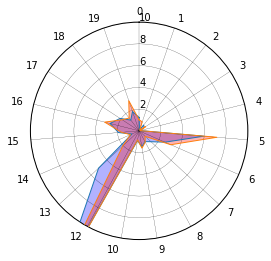

red - ntv
blue - tvrain


In [233]:
ntv_distr = groups_by_topic.groupby(by='ntv').aggregate('mean')*100
ntv_distr = ntv_distr.drop(columns=['index', 'tvrain', 11]).iloc[1].tolist()
tvrain_distr = groups_by_topic.groupby(by='tvrain').aggregate('mean')*100
tvrain_distr = tvrain_distr.drop(columns=['index', 'ntv', 11]).iloc[1].tolist()

# Set data
cat = [0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19]
values1 = ntv_distr
values2 = tvrain_distr
N = len(cat)
x_as = [n / float(N) * 2 * pi for n in range(N)]

values1 += values1[:1]
values2 += values2[:1]
x_as += x_as[:1]

# Set color of axes
plt.rc('axes', linewidth=1, edgecolor='#000000')
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(0)

# Set color and linestyle of grid
ax.xaxis.grid(True, color='#000000', linestyle='solid', linewidth=0.2)
ax.yaxis.grid(True, color='#000000', linestyle='solid', linewidth=0.2)

# Set number of radial axes and remove labels
plt.xticks(x_as[:-1], [])

# Plot data
ax.plot(x_as, values1, linewidth=1, linestyle='solid', zorder=3)
ax.fill(x_as, values1, 'b', alpha=0.3)
ax.plot(x_as, values2, linewidth=1, linestyle='solid', zorder=3)
ax.fill(x_as, values2, 'r', alpha=0.3)

# Set axes limits
plt.ylim(0, 10)

# Draw ytick labels to make sure they fit properly
for i in range(N):
    angle_rad = i / float(N) * 2 * pi
    if angle_rad == 0:
        ha, distance_ax = "center", 1
    elif 0 < angle_rad < pi:
        ha, distance_ax = "left", 1
    elif angle_rad == pi:
        ha, distance_ax = "center", 1
    else:
        ha, distance_ax = "right", 1
    ax.text(angle_rad, 10 + distance_ax, cat[i], size=10, horizontalalignment=ha, verticalalignment="center")
plt.show()
print('red - ntv\nblue - tvrain')

### Выводы по распределению интересов пользователей
Пятая колонная
- подписчики tvrain чаще слушают зарубежную музыку и увлекаются иностранными языками (топик 13)

Совпадение - не думаю
- подписчики ntv чаще интересуются локальными группами, новостями с района, барахолками и кулинарными каналами (топики 5, 12, 19) 


save_obj(check_pd_20, 'check_pd_20')
save_obj(final_data, 'final_data')
save_obj(groups_by_topic, 'groups_by_topic')
save_obj(uids, 'uids')
save_obj(subs_by_groups_ntv, 'subs_by_groups_ntv')
save_obj(subs_by_groups_tvrain, 'subs_by_groups_tvrain')

check_pd_20 = load_obj('check_pd_20')
final_data = load_obj('final_data')
groups_by_topic = load_obj('groups_by_topic')
uids = load_obj('uids')
subs_by_groups_ntv = load_obj('subs_by_groups_ntv')
subs_by_groups_tvrain = load_obj('subs_by_groups_tvrain')

Дополнительно:
- По любой группе пользователей построить матрицу Пользователь-Паблик, где 1 будет означать факт подписки на определенный паблик, 0 - отсутствие подписки (строки - пользователи, столбцы - паблики) и применить PCA - метод главных компонент, посмотреть, что из себя представляют топ-5 компонент и описать, какие интересы пользователей эти компоненты представляют

In [266]:
subs_by_groups_ntv = list(subs_by_groups_ntv)

In [312]:
ntv_matrix = []
counter = 0
uids_index = []
for uid in ntv_uids:
    ntv_usr = []
    try:
        usr_subs = final_data[uid].get('response').get('groups').get('items')[:5]
    except:
        continue
        
    for group in subs_by_groups_ntv:
        if group in usr_subs:
            ntv_usr.append(1)
        else:
            ntv_usr.append(0)
    
    ntv_matrix.append(ntv_usr)
    uids_index.append(uid)
    counter += 1
    if counter % 100 == 0:
        print("{0} uids processed".format(counter))

100 uids processed
200 uids processed
300 uids processed
400 uids processed
500 uids processed
600 uids processed
700 uids processed


In [313]:
ntv_matrix = pd.DataFrame(ntv_matrix, index = uids_index, columns=subs_by_groups_ntv)
ntv_matrix.head()

,103948290,130768908,142991372,164782094,93962259,34267158,32432151,147185688,129818649,28,...,58343385,24608732,75038686,171196388,39321576,38666219,74006511,89776115,150839288,71426046
293660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
775102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1514097,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1628253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1644238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [314]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 1)
ntv_matrix = ntv_matrix.transpose()
pca.fit(ntv_matrix)
X_pca = pca.transform(ntv_matrix)

In [329]:
decompose = []
for i in range(len(X_pca)):
    group = []
    group.append(subs_by_groups_ntv[i])
    group.append(X_pca[i][0])  
    decompose.append(group)

In [332]:
decompose = pd.DataFrame(decompose, columns=['Group_id', 'PCA_value'])

In [340]:
decompose.sort_values(by='PCA_value', ascending=False).head()

,Group_id,PCA_value
1010,28658784,12.431767
588,15755094,1.108378
1510,26211015,0.993917
1481,30462549,0.885492
1931,42743690,0.825147


Наиболее характеризующие подписчика НТВ группы

In [351]:
print("The most typical groups for NTV subscriber")
pca_ntv = decompose.sort_values(by='PCA_value', ascending=False).head()
pca_ntv = pca_ntv.reset_index()['Group_id'].tolist()
for g in pca_ntv:
    group_info = vk_get_response(
        'groups.getById', 'group_ids={0}&v=4.9&lang=ru'.format(g), access_token
    )
    print('\t',group_info['response'][0]['name'] + ' ' + 'http://vk.com/club' + str(g))
    time.sleep(0.4)
print()

The most typical groups for NTV subscriber
	 НТВ http://vk.com/club28658784
	 РИА Новости http://vk.com/club15755094
	 Jah Khalib http://vk.com/club26211015
	 Warner Music Russia http://vk.com/club30462549
	 Armin van Buuren http://vk.com/club42743690



Как ни странно:
- подписчик НТВ подписан на НТВ, и еще одно новостное издание
- увлекается музыкой